# ***DBSCAN clustering***

## ***Universidad Central***

## ***Maestría en analítica de datos***

## ***Métodos estadísticos para analítica de datos.***
## ***Docente: Luis Andrés Campos Maldonado.***

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
##
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (15,6)
warnings.filterwarnings("ignore")
url_base = "https://raw.githubusercontent.com/lacamposm/Metodos_Estadisticos/main/data/"

In [2]:
def improve_text_position(x):
  """"
      Esta función intercala las etiquetas en el texto de un plot en plotly
  """
  positions = ["top center", "bottom center"]
  return [positions[i % len(positions)] for i in range(len(x))]

In [3]:
def cluster_biplot(pca, dataframe, col_clusters, comp1=1, comp2=2, size_text=8 ):
  """
    Esta función construye el biplot de un PCA y muestra los cluster en el plano factorial.
    Input:  pca: Objeto pca que se usará para plotear los clusters.
            dataframe: pandas-DataFrame con el que se realizó el pca.
            col_cluster: Lista o pd.series con las etiquetas del asiganadas vía el método de cluster.
            comp1 = Componente en el eje x.
            comp2 = Compomente en el eje y
            size_text (int +): Tamáno del texto para buscar evitar overlapping.
    Output: Biplot con los clusters.
  """ 
  ## Trabajo con pca y dataframe.
  comp_1, comp_2 = str(comp1), str(comp2) ## Strings de las compomentes a plotear.
  scaler, length = StandardScaler(), len(pca.explained_variance_)
  percent_var = pca.explained_variance_ratio_*100
  scaler.fit(dataframe)
  X_scaled = scaler.transform(dataframe)
  ##
  tmp = dataframe.copy()
  if tmp.index.name == None:        ## En caso que el DataFrame no tenga nombre para el índice.
    tmp.index.name = "Indice"
  pca_trans = pd.DataFrame(pca.transform(X_scaled), index = tmp.index, 
                           columns = ["PC" + str(comp) for comp in range(1, length+1)])
  text_list = [pca_trans.index.name + ": {}".format(pca_trans.index[i]) for i in range(0,len(tmp))]

  features, tmp["cluster"]  = tmp.columns, col_clusters
  tmp["cluster"] = tmp["cluster"].astype("category")
  ##
  fig = px.scatter(tmp, x = pca_trans[f"PC{comp_1}"], y = pca_trans[f"PC{comp_2}"],color = "cluster",
                   text = tmp.index, hover_name=tmp.index, template = "plotly_white",symbol="cluster")
  ## Personalización plot
  fig.add_hline(y = 0,line_width = 0.5,line_dash="dash",line_color = "black")
  fig.add_vline(x = 0,line_width = 0.5,line_dash="dash",line_color = "black")
  fig.update_traces(textposition=improve_text_position(pca_trans[f"PC{comp_1}"]),
                    textfont_size = size_text,)
  fig.update_layout(title = "PCA-CLUSTER Biplot.")
  fig.update_xaxes(range = [min(pca_trans[f"PC{comp_1}"] - 0.35), max(pca_trans[f"PC{comp_1}"]) + 0.35], 
                   title_text = "Dim "+ comp_1 + " ({:.2f}%)".format(percent_var[comp1-1]))  
  fig.update_yaxes(range = [min(pca_trans[f"PC{comp_2}"] - 0.35), max(pca_trans[f"PC{comp_2}"]) + 0.35],
                   title_text = "Dim "+ comp_2+ " ({:.2f}%)".format(percent_var[comp2-1]))
  fig.show()

  return None

In [21]:
def knn_plot_dbscan(df, neighbor = 2):
  """
      Función que genera el plot para buscar seleccionar el valor de eps, en un clustering DBSCAN
      en sklearn.
      Input: pd.DataFrame con quien se ajustará el clustering DBSCAN
             neighbor (int >1): Numéro de vecinos cercanos deseados (puede usar 2*#_de_features)
      Output: None
  """
  from sklearn.neighbors import NearestNeighbors
  neigh = NearestNeighbors(n_neighbors=neighbor)
  nbrs = neigh.fit(df)
  distances, indices = nbrs.kneighbors(df)
  distances = distances[:,1:]
  distances = np.sort(np.mean(distances, axis = 1))
  fig = px.line(x = range(distances.shape[0]),y=distances, template="plotly_white")                
  fig.update_xaxes(title_text = "Points (sample) sorted by distance")
  fig.update_yaxes(title_text = "2-NN distance")
  fig.show()
  
  return None

## ***DBSCAN (Density-based spatial clustering of applications with noise)***

DBSCAN ("clustering con ruido basado en la densidad") es un algoritmo de clustering que busca la identificación de regiones "pobladas", es decir donde muchos registros están muy juntos, estas regiones se conocen como  ***regiones densas en el espacio de datos.***

La idea básica detrás de este enfoque de clustering se deriva de un método humano de agrupamiento intuitivo. Es decir, el cerebro humano puede identificar clusters observando los puntos que están cerca y además dejando sin ninguna asignación a registros que están aíslados (ruído). Así, ***los clusters son regiones densas en el espacio de datos, separadas por regiones de menor densidad de
puntos***. El algoritmo DBSCAN se basa en esta noción intuitiva de "clusters" y "ruido". La idea clave es que para cada punto de un cluster, la vecindad tiene que contener al menos un número mínimo de puntos.

Los principales beneficios de _DBSCAN_ son que no requiere que el usuario establezca el número de clusters a priori, puede capturar clusters de formas complejas y puede identificar puntos que no forman parte de ningún cluster. El algoritmo DBSCAN es algo más lento que el clustering aglomerativo y que $K$-means. Este algoritmo puede utilizarse para identificar clusters de cualquier forma en un Dataset que contenga ruido y valores atípicos.

## ***Ideas del método.***

La idea detrás de DBSCAN es que ***los clusters forman  regiones  densas de datos***, separadas por regiones que están relativamente vacías. Los puntos que están dentro de una región densa se denominan _core points_ (core points). Hay dos parámetros en DBSCAN: `min_samples` y `eps`. Si hay al menos `min_samples` puntos dentro de una distancia `eps` ($ϵ$-vecindad), ese punto se clasifica como un _core point_.  _Core points_ que están más cerca
entre sí que la distancia `eps` el algoritmo DBSCAN los coloca en el mismo cluster.

El algoritmo funciona eligiendo un punto arbitrario para comenzar. Luego encuentra ***todos los puntos con distancia menor o igual a la dada en `eps` (definición de $ϵ$-vecindad)***. Si hay menos de `min_samples` puntos dentro de la distancia `eps` del punto de partida, ***este punto se etiqueta como ruido,  lo que significa que no pertenece a ningún cluster (por ahora)***. Si hay más de `min_samples` puntos dentro de una distancia `eps`, el punto se etiqueta como _core point_ y se le asigna una nueva etiqueta de cluster. Luego, se visitan todos los vecinos ("viaja" por la $ϵ$-vecindad)  del punto, a estos puntos se les asigna la nueva etiqueta de cluster que se acaba de crear. Si
son _core points_, sus vecinos son visitados a su vez, y así sucesivamente. El cluster crece hasta que no hay más _core points_ a una distancia `eps` del cluster. Después
se elige otro punto que aún no ha sido visitado, y se sigue el mismo procedimiento anterior.



<center>

***ALGORITMO DBSCAN***

<img src="https://miro.medium.com/proxy/1*tc8UF-h0nQqUfLC8-0uInQ.gif" alt="drawing" width="600" height = "300"/>

</center>



## ***Algoritmo DBSCAN***

Vamos a definir tres conceptos:

- ***Core point:*** Una observación que tiene en su $ϵ$-vecindad un número de observaciones vecinas igual o mayor que `min_sample`.

- ***Boder point:*** Una observación que no satisface el número mínimo de observaciones vecinas para ser _core point_, pero pertenece a la $ϵ$-vecindad de otra observación que si es _core point_.

- ***Noise u outlier:*** Una observación que no es _core point_ ni _border point_.

Basados en las tres categorías anteriores se pueden definir tres niveles de conectividad entre observaciones:

- ***Directamente alcanzable (direct density reachable):*** Una observación $B$ es directamente alcanzable desde otra observación $A$ si $B$ forma parte de la $ϵ$-vecindad de $A$ y $A$ es un _core point_. Por definición, las observaciones solo pueden ser directamente alcanzables desde un _core point_.

- ***Alcanzable (density reachable):*** Una observación $A$ es alcanzable desde otra observación $B$ si existe una secuencia de _core points_ que van desde $B$ a $A$.

- ***Densamente conectadas (density conected):*** Dos observaciones $B$ y $C$ están densamente conectadas si existe una observación $A$ que es un _core point_, tal que $B$ y $C$ son alcanzables desde $A$.

<center>

<img src="https://raw.githubusercontent.com/lacamposm/Metodos_Estadisticos/main/data/images/DBSCAN-Illustration.svg" alt="drawing" width="400" height = "200"/>

***Tomado de [wikipedía](https://es.wikipedia.org/wiki/DBSCAN)***

</center>



***La imagen anterior muestra las conexiones existentes entre un conjunto de observaciones con `min_samples=4`. La observación $A$ y el resto de observaciones marcadas con rojo son core points, ya que todas ellas contienen al menos 4 observaciones vecinas (incluyéndose a ellas mismas) en su $\epsilon$-vecindad. Como todas son alcanzables entre ellas, forman un cluster. Las observaciones $B$ y $C$ no son core points, pero son densamente alcanzables desde $A$ y densamente conectados con A, y por lo tanto pertenecen al mismo clúster. La observación $N$ no es ni _core point_ ni es directamente alcanzable, por lo tanto se considera como noise (ruido)***

### ***Algoritmo.***

1. Para cada observación $x_i$ calcular la distancia entre ella y el resto de observaciones. Si en su $ϵ$-vecindad hay un número de observaciones ***mayor o igual*** a `min_sample` marcar la observación como _core point_, de lo contrario marcarla como visitada.

2. Para cada observación $x_i$ marcada como _core point_, si todavía no ha sido asignada a ningún cluster, crear uno nuevo y asignarla a él. Encontrar recursivamente ***todas las observaciones densamente conectadas a ella*** y asignarlas al mismo cluster.

3. Iterar el mismo proceso para todas las observaciones que no hayan sido visitadas.

4. Aquellas observaciones que tras haber sido visitadas no pertenecen a ningún cluster se marcan como outliers.



***NOTA:*** Como resultado, todo cluster cumple dos propiedades: 

1. Todos los puntos que forman parte de un mismo cluster están ***densamente conectados entre ellos.***

2. Si una observación $A$ es ***densamente alcanzable desde cualquier otra observación*** de un cluster, entonces $A$ también pertenece al cluster.

## ***Selección de parámetros.***

Como ocurre en muchas otras técnicas estadísticas, en DBSCAN no existe una forma única y exacta de encontrar el valor adecuado de epsilon (`eps`) y `min_samples`. A modo orientativo se pueden seguir las siguientes premisas:

- `min_samples`: Cuanto mayor sea el tamaño del Dataset, mayor debe ser el valor mínimo de observaciones vecinas. En el libro de la referencia 1, recomiendan no bajar nunca de 3. Si los datos contienen niveles altos de ruido, aumentar `min_samples` favorecerá la creación de clusters significativos menos influenciados por outliers.

- `eps`: Una buena forma de escoger este valor consiste en calcular las $k$-distancias vecinas más cercanas. Seguido, calcular el promedio de esas distancias. El valor de $k$ será especificado por el usuario y corresponde a `min_samples`. Luego, estas $k$-distancias se trazan en orden ascendente. El objetivo es determinar la “rodilla”, que corresponde al parámetro `eps` óptimo. Una rodilla corresponde a un umbral donde se produce un cambio brusco a lo largo de la curva de las $k$ distancias. Si el valor de `eps` escogido es muy pequeño, una proporción alta de las observaciones no se asignarán a ningún cluster, por el contrario, si el valor es demasiado grande, la mayoría de observaciones se agruparán en un único cluster.

### ***Ventajas de DBSCAN.***

- A diferencia de $K$-means, DBSCAN no requiere que el usuario especifique el número de clusters a generar.

- DBSCAN es independiente de la forma que tengan los clusters, no tienen por qué ser circulares.

- DBSCAN puede identificar outliers, por lo que los clusters generados no son influenciados por ellos.




### ***Desventajas de DBSCAN.***

- No es un método totalmente determinístico: los border points que son alcanzables desde más de un cluster pueden asignarse a uno u otro dependiendo del orden en el que se procesen los datos.

- No genera buenos resultados cuando la densidad de los grupos es muy distinta, ya que no es posible encontrar los parámetros `eps` y `min_samples` que sirvan para todos a la vez.

## ***Ejemplo 1.***

Vamos a hacer uso de [`sklearn.cluster.DBSCAN`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) para trabajar con el algoritmo.

In [5]:
USArrests = pd.read_csv(url_base + "USArrests.csv", index_col=0)
USArrests.head()

Murder  Assault  UrbanPop  Rape
Alabama       13.2      236        58  21.2
Alaska        10.0      263        48  44.5
Arizona        8.1      294        80  31.0
Arkansas       8.8      190        50  19.5
California     9.0      276        91  40.6

In [6]:
## Escalamos la información.
scaler = StandardScaler()
scaler.fit(USArrests)
##
df = pd.DataFrame(scaler.transform(USArrests), columns = USArrests.columns, index = USArrests.index)
df.head(6)

Murder   Assault  UrbanPop      Rape
Alabama     1.255179  0.790787 -0.526195 -0.003451
Alaska      0.513019  1.118060 -1.224067  2.509424
Arizona     0.072361  1.493817  1.009122  1.053466
Arkansas    0.234708  0.233212 -1.084492 -0.186794
California  0.281093  1.275635  1.776781  2.088814
Colorado    0.025976  0.402909  0.869548  1.883901

In [7]:
knn_plot_dbscan(df,neighbor=8)

In [8]:
from sklearn.cluster import DBSCAN
## Creamos una instancia de DBSCAN
clustering = DBSCAN(eps=1.40, min_samples = 8)
clustering.fit(df)
np.unique(clustering.labels_, return_counts=True)

(array([-1,  0,  1,  2]), array([ 2,  8, 10, 30]))

In [9]:
## Ajustamos un PCA
pca = PCA(n_components=0.99)
pca.fit(df)
pca_array = pca.transform(df) 

In [10]:
## Plot con 2 clusters.
cluster_biplot(pca,USArrests,clustering.labels_,size_text=5)

In [11]:
## Comparando clusters.
df_Cluster = USArrests.copy()
df_Cluster["cluster"] = clustering.labels_
df_Cluster.head()

Murder  Assault  UrbanPop  Rape  cluster
Alabama       13.2      236        58  21.2        0
Alaska        10.0      263        48  44.5       -1
Arizona        8.1      294        80  31.0        1
Arkansas       8.8      190        50  19.5        0
California     9.0      276        91  40.6        1

In [12]:
df_cluster_plot = df_Cluster[df_Cluster["cluster"] !=-1]
df_cluster_plot["cluster"] = df_cluster_plot["cluster"].astype("category")

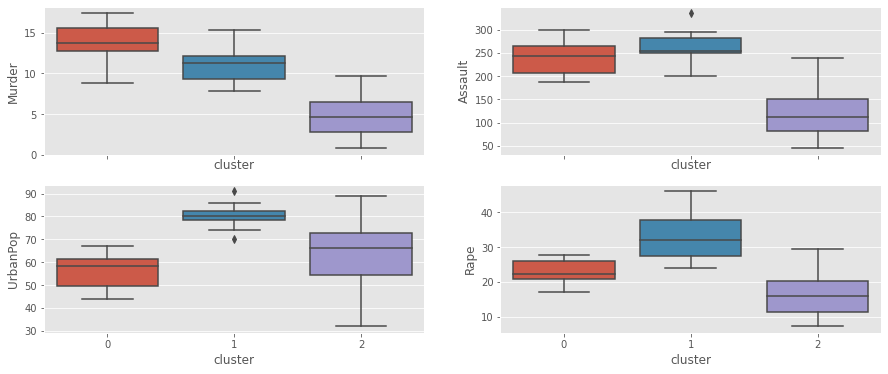

In [13]:
## Box-plots
fig, axes = plt.subplots(2,2, sharex=True)
##
sns.boxplot(data=df_cluster_plot, x = "cluster", y = "Murder", ax = axes[0,0])
sns.boxplot(data=df_cluster_plot, x = "cluster", y = "Assault", ax = axes[0,1])
sns.boxplot(data=df_cluster_plot, x = "cluster", y = "UrbanPop", ax = axes[1,0])
sns.boxplot(data=df_cluster_plot, x = "cluster", y = "Rape", ax = axes[1,1])
plt.show()

## ***Comparando métodos de clustering***

Uno de los desafíos en la aplicación de algoritmos de agrupamiento es que es muy difícil evaluar
qué tan bien funcionó un algoritmo y comparar los resultados entre diferentes algoritmos. Después de hablar sobre los algoritmos detrás de K$-means, el clustering aglomerativo y DBSCAN, los vamos a comparar en un conjunto de datos particular.

In [14]:
from sklearn.datasets import make_moons
from sklearn.cluster import AgglomerativeClustering, KMeans
X, y = make_moons(n_samples=1000, noise=0.05, random_state=0)
X = pd.DataFrame(X, columns = ["feature_1","feature_2"])
X.head()

feature_1  feature_2
0   2.021001   0.490179
1   1.678201  -0.201987
2  -0.282245   0.858785
3  -0.021440   0.176281
4   0.504842  -0.391043

In [15]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
df_scaled = pd.DataFrame(X_scaled, columns = ["feature_1","feature_2"])
df_scaled.head()

feature_1  feature_2
0   1.750819   0.483940
1   1.356064  -0.907069
2  -0.901504   1.224707
3  -0.601172  -0.146884
4   0.004873  -1.287005

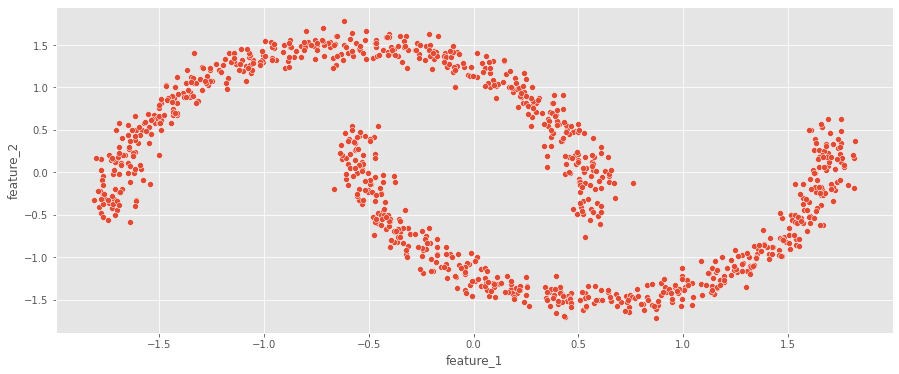

In [16]:
## Nube de puntos original.
sns.scatterplot(data = df_scaled, x="feature_1", y = "feature_2")
plt.show()

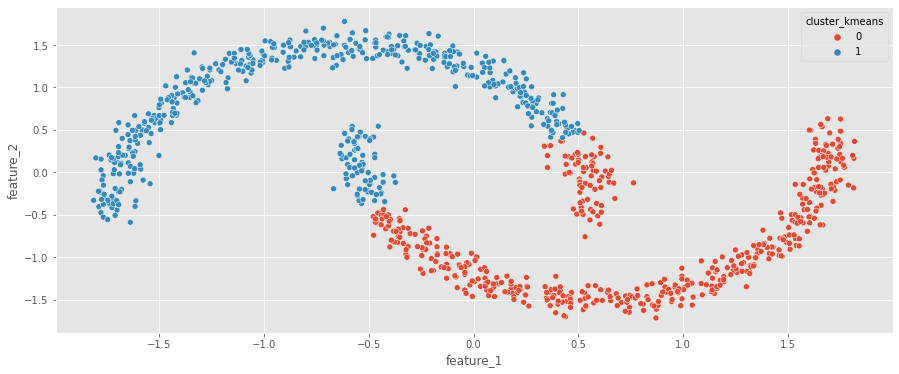

In [17]:
## Con k-means.
df_kmeans = df_scaled.copy()
kmeans = KMeans(n_clusters=2)
kmeans.fit(df_kmeans)
df_kmeans["cluster_kmeans"] = kmeans.labels_
##
sns.scatterplot(data = df_kmeans, x = "feature_1", y = "feature_2", hue = "cluster_kmeans")
plt.show()

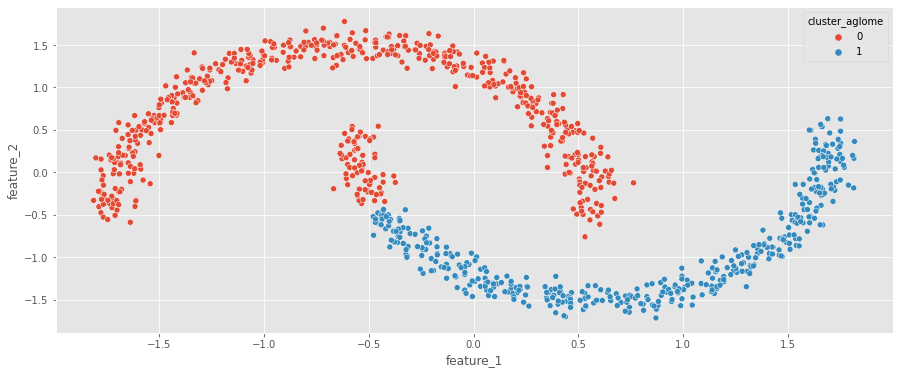

In [18]:
## Con AgglomerativeClustering
df_aglome = df_scaled.copy()
aglome = AgglomerativeClustering(n_clusters=2)
aglome.fit(df_aglome)
df_aglome["cluster_aglome"] = aglome.labels_
##
sns.scatterplot(data = df_aglome, x = "feature_1", y = "feature_2", hue = "cluster_aglome")
plt.show()

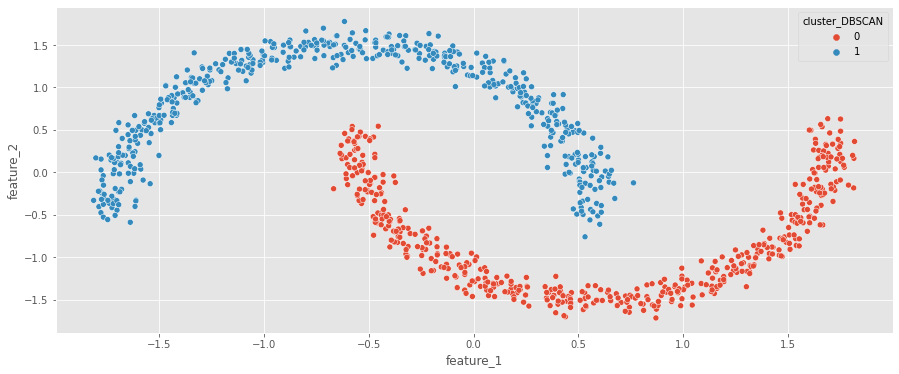

In [19]:
## Con DBSCAN
df_dbscan = df_scaled.copy()
dbscan = DBSCAN(eps = 0.2, min_samples=4)
dbscan.fit(df_dbscan)
df_dbscan["cluster_DBSCAN"] = dbscan.labels_
##
sns.scatterplot(data = df_dbscan, x = "feature_1", y = "feature_2", hue = "cluster_DBSCAN")
plt.show()

***Note el único método que segmentó de manera adecuada fue DBSCAN.***

Cuando se aplican algoritmos de clustering, por lo general no existe una "verdad" básica con la cual comparar los resultados. Hay métricas de puntuación para el clustering como el coeficiente de silueta. Este coeficiente calcula la compacidad de un clúster, donde un valor más alto es mejor, con una puntuación perfecta de 1. Si bien los clústeres compactos son buenos, la compacidad no trabaja bien en formas complejas
formas.

In [20]:
from sklearn.metrics import silhouette_score
###
algoritmos = [kmeans, aglome, dbscan]
###
for algoritmo in algoritmos:
  clusters = algoritmo.fit_predict(X_scaled)
  a = silhouette_score(X_scaled, clusters)
  print("Algoritmo:",algoritmo,"---> silhouette_score:",a)

Algoritmo: KMeans(n_clusters=2) ---> silhouette_score: 0.49877630129450223
Algoritmo: AgglomerativeClustering() ---> silhouette_score: 0.4565104953195905
Algoritmo: DBSCAN(eps=0.2, min_samples=4) ---> silhouette_score: 0.3915969903000845


$K$-means obtiene la puntuación de silueta más alta, aunque se prefiere el resultado obtenido por DBSCAN.

## ***Referencias:***

1. _Multivariate Analysis I. Kassambara A. Disponible en: http://www.sthda.com/english/_

2. _Introduction to machine learning with Python: a guide for data scientists. Müller, A. C., & Guido, S. (2016).  O'Reilly Media, Inc._